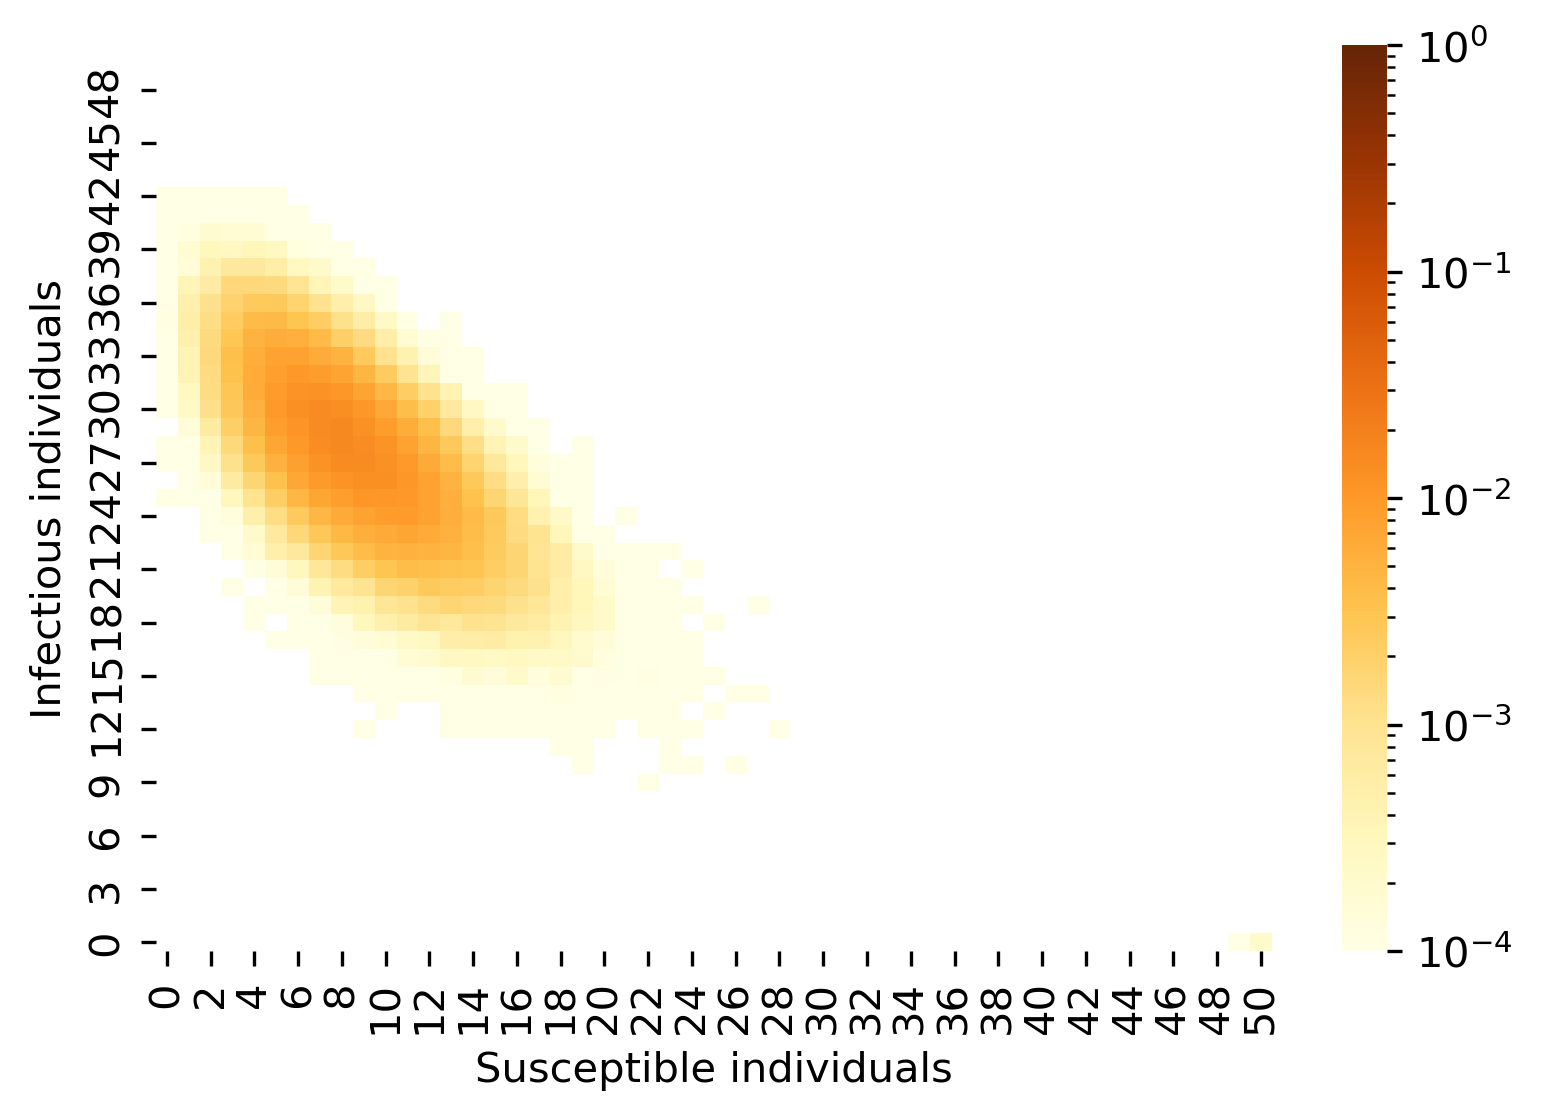

In [9]:
import numpy as np
import pylab as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib
### You may want to try with popylation size of 50 (small) to see the events
### In this case uncomment the next line
#N0=50.0
S0=45
I0=5
R0=0
beta=3.0
gamma=0.5
zeta=1.0
popsize=50
nreacciones=3
Tmax=5.0
tau=0.05
np.random.seed(0)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res
    
def stoc_eqs(INP,beta,gamma,zeta,N,nreacciones): 
    V = INP
    Rate=np.zeros((nreacciones))
    Change=np.zeros((nreacciones,len(V)))
    N=V[0]+V[1]+V[2]
    Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0])
    Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1])
    Rate[2] = zeta*V[2];  Change[2,:]=([+1, 0, -1])
    for i in range(nreacciones):
        K_i=np.random.poisson(Rate[i]*tau)
        K_i=min([K_i, V[find(Change[i,:]<0)]])
        V=V+Change[i,:]*K_i
    return V

def Stoch_Iteration(INPUT,beta,gamma,zeta,N,nreacciones,T):
    lop=0
    S=[]
    I=[]
    R=[]
    SI=[]
    for lop in T:
        res = stoc_eqs(INPUT,beta,gamma,zeta,N,nreacciones)
        S.append(INPUT[0])
        I.append(INPUT[1])
        R.append(INPUT[2])
        SI.append((INPUT[0],INPUT[1]))
        INPUT=res
    return S,I,R
def one_trajectory(S0,I0,R0,beta,gamma,zeta,N,nreacciones,Tmax,tau):
    INPUT = np.array((S0,I0,R0))
    T=np.arange(0.0, Tmax, tau)
    [S,I,R]=Stoch_Iteration(INPUT,beta,gamma,zeta,N,nreacciones,T)
    return S,I
matplotlib.rcParams['figure.dpi'] = 300
T=np.arange(0.0, Tmax, tau)
matrs=[[[0.0 for i in range(popsize+1)]for j in range(popsize+1)] for k in range(len(T))]
nsims=100000
for l in range(nsims):
    S,I=one_trajectory(S0,I0,R0,beta,gamma,zeta,popsize,nreacciones,Tmax,tau)
    for i in range(len(T)):
        matrs[i][int(I[i])][int(S[i])]+=1
def plotter(matriz,title):
    fig=sns.heatmap(matriz,cmap="YlOrBr",norm=LogNorm(vmin=0.0001, vmax=1)) #vmax=0.1
    plt.title(title)
    plt.xlabel("Susceptible individuals")
    plt.ylabel("Infectious individuals")
    plt.ylim(0,popsize+1)
    plt.xlim(0,popsize+1)
    plt.show()
plotter(np.array(matrs[-1])/nsims,"")

In [15]:
import math as ma
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time as ti
import scipy.linalg as la
import scipy
from scipy.integrate import odeint
import copy
from matplotlib.colors import LogNorm
def Returner(S,I,popsize):
    u=[]
    for i in range(popsize+1):
        for j in range(popsize+1):
            u.append([j,i])
    return u.index([S,I])
def Returnerinv(k,popsize):
    u=[]
    for i in range(popsize+1):
        for j in range(popsize+1):
            u.append([j,i])
    return u[k]       
def pa(S,I,N,beta,gamma):
    if I==0 or S+I>N:
        return [0]
    else:
        return [[S+1,I-1], beta*(I-1)*(S+1)]
        
def pb(S,I,N,beta,gamma):
    if N-S-I==0 or S+I>N:
        return [0]
    else: 
        return [[S,I+1], gamma*(I+1)]  
        
def pc(S,I,N,beta,gamma,zeta):
    if S+I>N:
        return [0]
    else:
        return [[S,I], -beta*S*I-gamma*I-zeta*(N-S-I)]
        
def pd(S,I,N,beta,gamma,zeta):
    if S==0 or S+I>N:
        return [0]
    else: 
        return [[S-1,I], zeta*(N-S-I+1)]    
        
def vec_creator(S,I,N,beta,gamma,zeta):
    vvector=[0.0 for i in range ((N+1)*(N+1))]
    if len(pa(S,I,N,beta,gamma))==2:
        a=pa(S,I,N,beta,gamma)
        vvector[Returner(a[0][0],a[0][1],N)]=a[1]
    if len(pb(S,I,N,beta,gamma))==2:
        b=pb(S,I,N,beta,gamma)
        #print(Returner(b[0][0],b[0][1],N))
        vvector[Returner(b[0][0],b[0][1],N)]=b[1]
    if len(pc(S,I,N,beta,gamma,zeta))==2:
        c=pc(S,I,N,beta,gamma,zeta)
        vvector[Returner(c[0][0],c[0][1],N)]=c[1]
    if len(pd(S,I,N,beta,gamma,zeta))==2:
        d=pd(S,I,N,beta,gamma,zeta)
        vvector[Returner(d[0][0],d[0][1],N)]=d[1]
    return vvector
#print(vec_creator(2,1,2,1,5))
    


def Matrix_form_generator(popsize,beta,gamma,zeta):
    siuuu=[]
    for i in range(popsize+1):
        for j in range(popsize+1):
            #print(j,i)
            siuuu.append(vec_creator(j,i,popsize,beta,gamma,zeta))
    return np.array(siuuu).T

def phase_plotter(pvec,popsize,name,boole,title):
    #print(np.sum(pvec))
    phase_matrix=[[0.0 for i in range(popsize+1)]for j in range(popsize+1)]
    for i in range(popsize+1):
        for j in range(popsize+1): 
            phase_matrix[j][i]=pvec[Returner(j,i,popsize)]
    phase_matrix=np.array(phase_matrix)
    #fig=sns.heatmap(phase_matrix.T,cbar=boole) #vmax=0.1
    fig=sns.heatmap(phase_matrix.T,cmap="YlOrBr",norm=LogNorm(vmin=0.0001, vmax=1))
    plt.title(title)
    plt.xlabel("Susceptible individuals")
    plt.ylabel("Infectious individuals")
    plt.ylim(0,popsize+1)
    plt.xlim(0,popsize+1)
    #plt.savefig("images2/"+str(name)+".png")
    #plt.close()
    if boole:
        return None
    else: 
        return phase_matrix
def prom(yvec):
    prom=0
    for i in range(len(yvec)): 
        prom+=i*yvec[i]
    return prom
popsize=50
beta=3.0
gamma=0.5
zeta=1.0
I0=5
R0=0
S0=popsize-I0-R0 #R0=0
A=Matrix_form_generator(popsize,beta/popsize,gamma,zeta)
print("The evolution matrix has been generated, the size is ", A.shape)
def deriv(y, t, N, beta, gamma,zeta):
    S, I, R = y
    dSdt = -beta * S * I / N + zeta * R
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I - zeta * R 
    return dSdt, dIdt, dRdt


y0=[0.0 for i in range((popsize+1)*(popsize+1))]
y0[Returner(S0,I0,popsize)]=1.0
y0=np.array(y0)
dt=0.03
npuntos=150
times=[0.0+i*dt for i in range(npuntos)]
times=np.array(times)
yvalp=y0
Liu=la.expm(dt*A)
print("exp(dt*A) has been calculated")
prob0=[]
prob1=[]
prob2=[]
tmat=[]
print("I've calculated ", 0, " times from ",npuntos) 
# The SIR model differential equations.
N=popsize
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
t=times
def det_plotter(y0,t,N,beta,gamma,zeta,i):
    ret = odeint(deriv, y0, t[:i+1], args=(N, beta, gamma,zeta))
    S, I, R = ret.T    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.title("t="+"{0:.2f}".format(t[i]))
    plt.xlabel("Susceptible individuals")
    plt.ylabel("Infectious individuals")
    plt.ylim(0,N+1)
    plt.xlim(0,N+1)
    #plt.scatter(S[-1],I[-1],marker="X",color="black")
    #plt.plot(S,I,"--",color="gray")
    plt.savefig("imagesSIRS/"+str(i)+"f.png")
    #plt.show()
    plt.close()
for i in range(npuntos):
    if i==npuntos:
        phase_plotter(yvalp,popsize,i+1,True,"t="+"{0:.2f}".format(i*dt))
        det_plotter(y0,t[:i+1],N,beta,gamma,zeta,i)
    yval = np.dot(yvalp,Liu)
    print("I've calculated ", i, " times from ",npuntos,end="\r") 
    yvalp=yval

The evolution matrix has been generated, the size is  (2601, 2601)
exp(dt*A) has been calculated
I've calculated  0  times from  150


0.06617448454418283

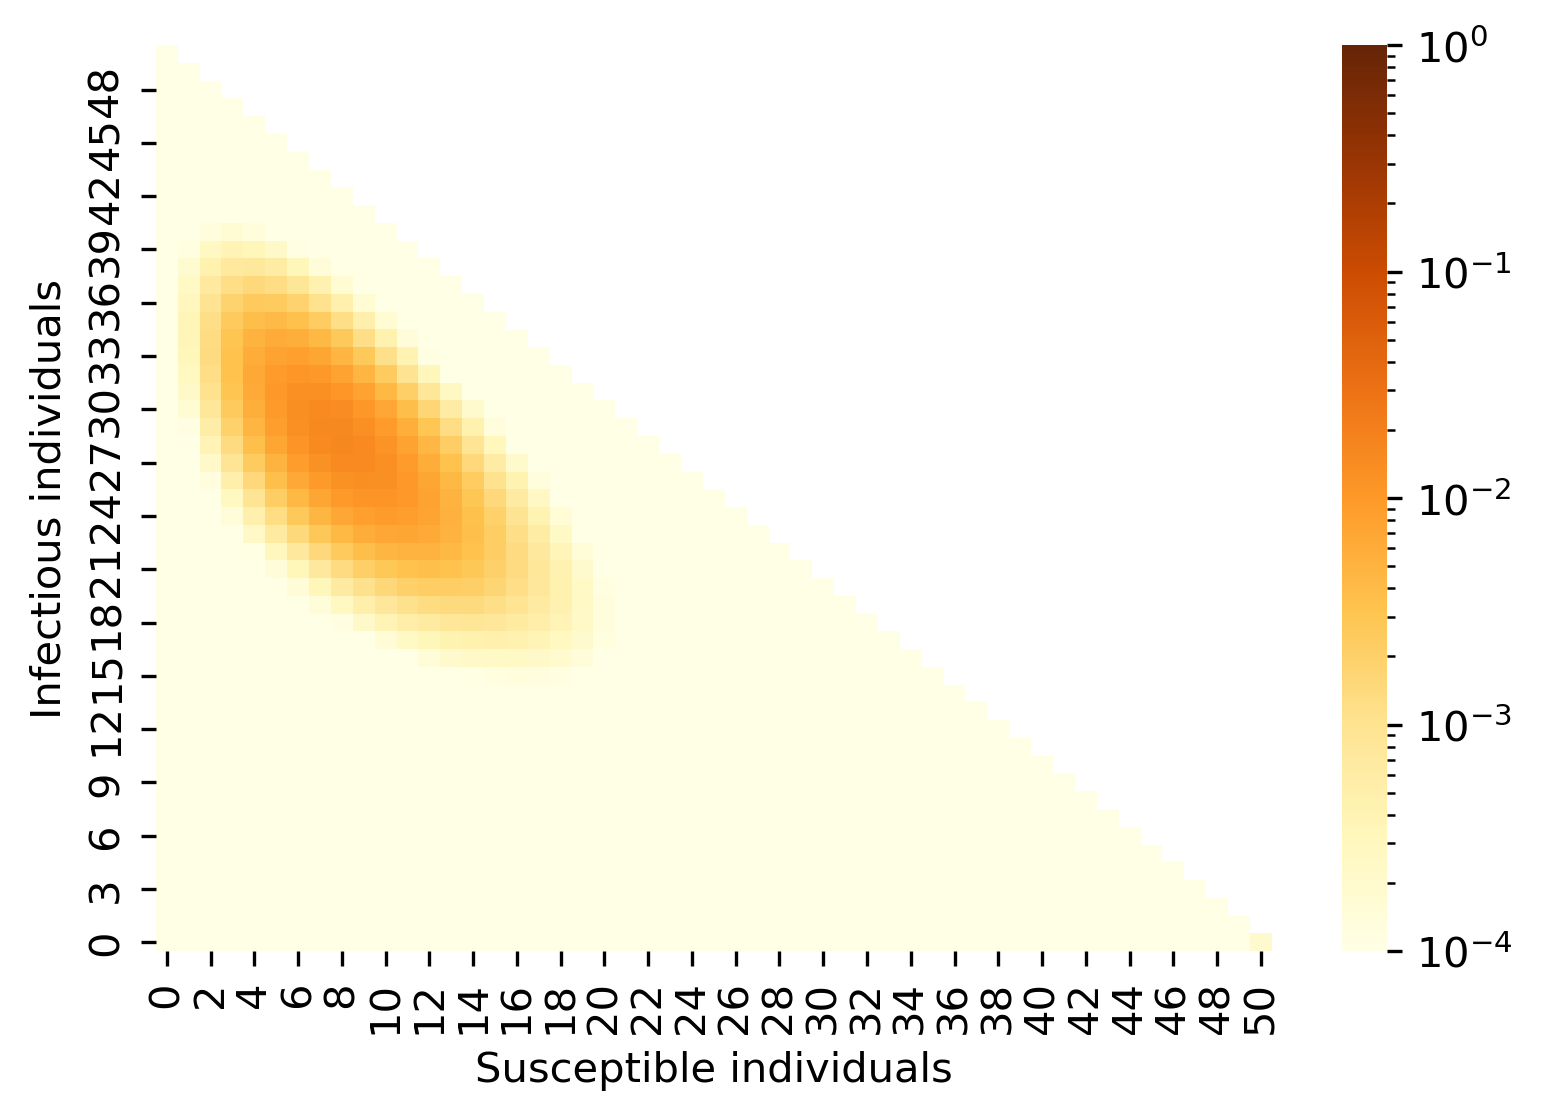

In [26]:
b=phase_plotter(yvalp,popsize,"",False,"")

a=np.array(matrs[-1])/nsims
np.sum(abs(a-b.T))

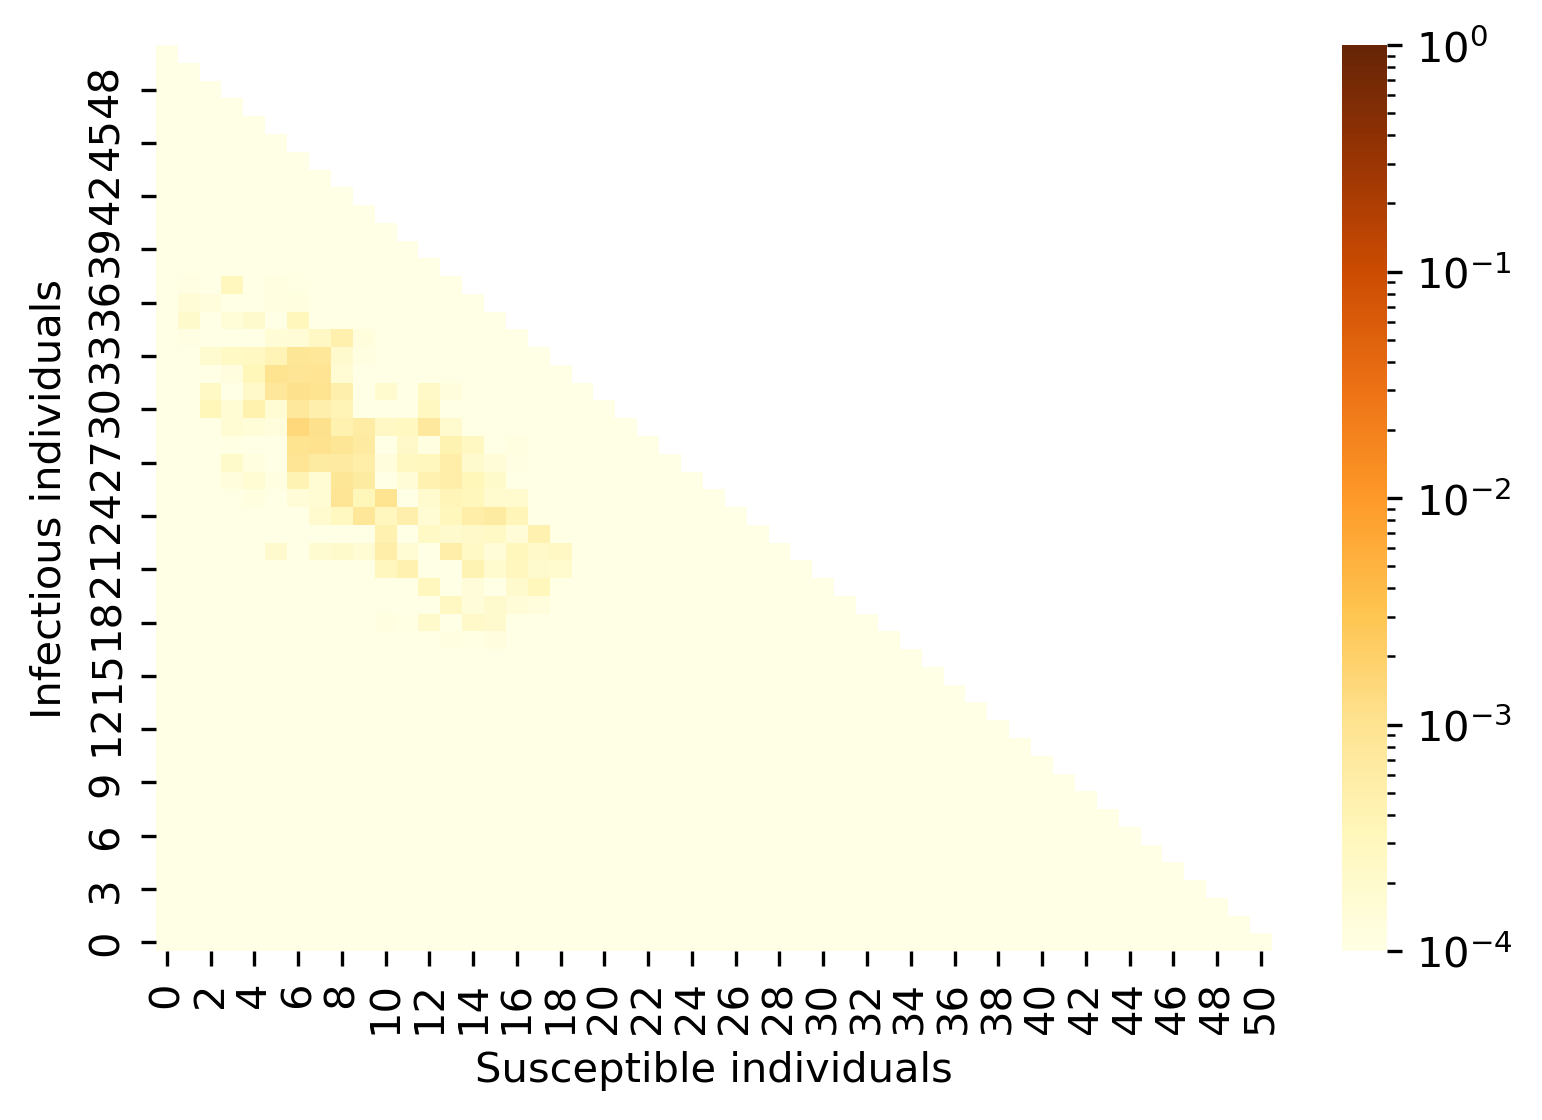

In [27]:
plotter(abs(a-b.T),"")